<a href="https://colab.research.google.com/github/akhilramola/FAKE_NEWS_DETECTION/blob/main/Untitled15.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import re
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import nltk
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import classification_report, confusion_matrix
import joblib
import matplotlib.pyplot as plt
import seaborn as sns
import gradio as gr

In [2]:
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


True

In [7]:



# Paths to the CSV files
fake_path = "/content/Fake.csv"
true_path = "/content/True.csv"

# Load datasets
fake_df = pd.read_csv(fake_path)
true_df = pd.read_csv(true_path)

# Add label column
fake_df['label'] = 1  # Fake news
true_df['label'] = 0  # Real news

# Combine datasets
df = pd.concat([fake_df, true_df], ignore_index=True)

In [8]:
# Preprocessing function
stop_words = set(stopwords.words('english'))
def clean_text(text):
    if not isinstance(text, str):
        return ""
    text = text.lower()
    text = re.sub(r'http\S+|www\S+', '', text)  # Remove URLs
    text = re.sub(r'[^a-zA-Z\s]', '', text)  # Remove special chars and numbers
    tokens = word_tokenize(text)
    tokens = [word for word in tokens if word not in stop_words]
    return ' '.join(tokens)

In [9]:
# Apply cleaning and combine title and text
df['clean_text'] = df['text'].apply(clean_text)
df['clean_title'] = df['title'].apply(clean_text)
df['combined_text'] = df['clean_title'] + ' ' + df['clean_text']


In [10]:
# Basic EDA
print("Dataset Info:")
print(df.info())
print("\nLabel distribution:")
print(df['label'].value_counts(normalize=True))
print("\nSubject distribution:")
print(df['subject'].value_counts())

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 44898 entries, 0 to 44897
Data columns (total 8 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   title          44898 non-null  object
 1   text           44898 non-null  object
 2   subject        44898 non-null  object
 3   date           44898 non-null  object
 4   label          44898 non-null  int64 
 5   clean_text     44898 non-null  object
 6   clean_title    44898 non-null  object
 7   combined_text  44898 non-null  object
dtypes: int64(1), object(7)
memory usage: 2.7+ MB
None

Label distribution:
label
1    0.522985
0    0.477015
Name: proportion, dtype: float64

Subject distribution:
subject
politicsNews       11272
worldnews          10145
News                9050
politics            6841
left-news           4459
Government News     1570
US_News              783
Middle-east          778
Name: count, dtype: int64


In [11]:
# Feature extraction with TF-IDF
tfidf = TfidfVectorizer(max_features=5000)
X = tfidf.fit_transform(df['combined_text'])
y = df['label']


In [12]:
# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train Logistic Regression model
model = LogisticRegression(max_iter=1000)
model.fit(X_train, y_train)


LogisticRegression(max_iter=1000)

In [13]:
# Cross-validation scores
cv_scores = cross_val_score(model, X, y, cv=5)
print("Cross-validation scores:", cv_scores)
print("Average CV score:", cv_scores.mean())


Cross-validation scores: [0.98452116 0.98340757 0.97572383 0.97661209 0.98028734]
Average CV score: 0.9801103986510469


In [14]:
# Evaluate on test set
y_pred = model.predict(X_test)
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=['Real', 'Fake']))


Classification Report:
              precision    recall  f1-score   support

        Real       0.99      0.99      0.99      4247
        Fake       0.99      0.99      0.99      4733

    accuracy                           0.99      8980
   macro avg       0.99      0.99      0.99      8980
weighted avg       0.99      0.99      0.99      8980



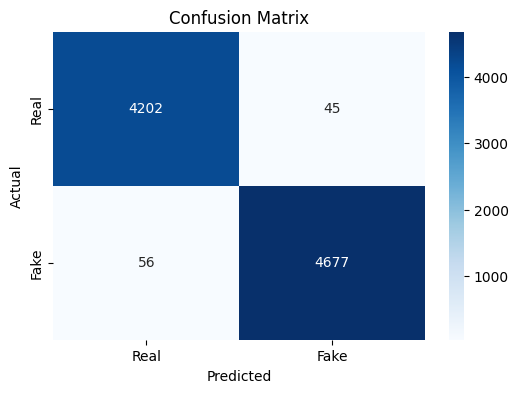

In [15]:
# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Real', 'Fake'], yticklabels=['Real', 'Fake'])
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


In [16]:
# Save model and vectorizer
joblib.dump(model, '/content/fake_news_model.pkl')
joblib.dump(tfidf, '/content/tfidf_vectorizer.pkl')

# Gradio prediction function
def predict_news(title, text):
    combined = clean_text(title) + ' ' + clean_text(text)
    combined_tfidf = tfidf.transform([combined])
    prediction = model.predict(combined_tfidf)[0]
    probability = model.predict_proba(combined_tfidf)[0]
    label = "Fake" if prediction == 1 else "Real"
    prob_fake = probability[1] * 100
    prob_real = probability[0] * 100
    return f"Prediction: {label}\nProbability (Fake): {prob_fake:.2f}%\nProbability (Real): {prob_real:.2f}%"


In [17]:
# Gradio interface
interface = gr.Interface(
    fn=predict_news,
    inputs=[
        gr.Textbox(label="News Title", placeholder="Enter the news article title..."),
        gr.Textbox(label="News Text", placeholder="Enter the news article text...", lines=5)
    ],
    outputs=gr.Text(label="Prediction"),
    title="Fake News Detector",
    description="Enter a news article's title and text to predict if it's fake or real."
)

In [18]:
interface.launch()

It looks like you are running Gradio on a hosted a Jupyter notebook. For the Gradio app to work, sharing must be enabled. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://0ab00fd1156696756e.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
